1. Pasar de .FR a .npy en un dia
2. Regiones para tomar las imagenes y tamaños que quedan cada una
3. Como cargamos las imagenes a memoria
4. Persistencia, persistencia borrosa, cmv
5. Visualizacion de las imagenes, ventana que saca nans, predicciones, ventana sin nans
6. Evaluacion de las predicciones
7. Dataset, outliers, tamaño del dataset restante, etc

In [1]:
from src.data import save_imgs_list_2npy
import os
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

from torch.utils.data import DataLoader

from src import data, evaluate, model, preprocessing, visualization
from src.lib import utils

plt.rcParams['figure.figsize'] = [8, 5]

# 1. Pasar de .FT a .npy de un dia

In [13]:
df_dataset = pd.read_csv("reports/dataset_2020.csv")
imgs_list_day1 = []

M = len(df_dataset.values[0][2])
str_list = df_dataset.values[0][2][1:M-1].replace('\'',"" )
str_list = str_list.replace(" ", "")
imgs_list_day1 = str_list.split(",")
    

path = '/solar/sat/art-rrr/ART_G010x010RR_C010x010/' 
to_fr = 'C02-FR/2020/'
to_mk = 'C02-MK/2020/'
to_meta = 'meta/'

save_imgs_list_2npy(
    imgs_list=imgs_list_day1,
    meta_path= os.path.join(path, to_meta),
    mk_folder_path= os.path.join(path, to_mk),
    img_folder_path= os.path.join(path, to_fr),
    destintation_path='data/images'
)

# 2. Regiones para tomar las imagenes y tamaños que quedan cada una

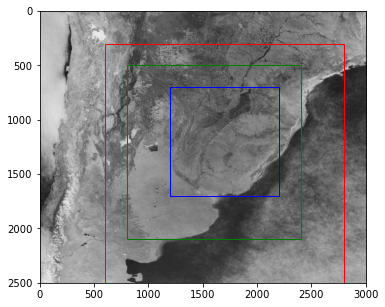

In [22]:
bkg = cv.imread('misc/bkg.png')

fig, ax = plt.subplots()

rect1 = patches.Rectangle((1200, 700), 1000, 1000, linewidth=1, edgecolor='b', facecolor='none') # xy, w, h
ax.add_patch(rect1)
rect2 = patches.Rectangle((800, 500), 1600, 1600, linewidth=1, edgecolor='g', facecolor='none')
ax.add_patch(rect2)
rect2 = patches.Rectangle((600, 300), 2200, 2200, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect2)

ax.imshow(bkg)


# 3. Como cargamos las imagenes a memoria

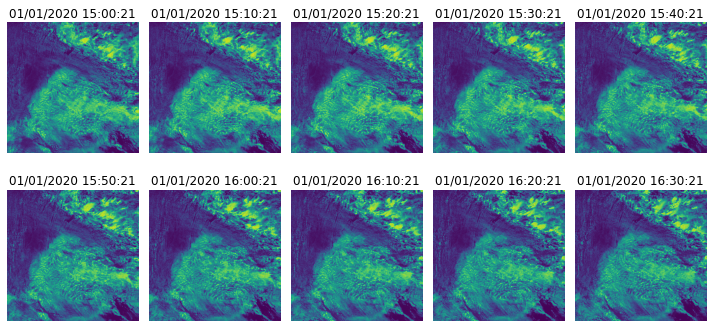

In [2]:
dataset_sw = data.SatelliteImagesDatasetSW(root_dir = 'data/images/dia_1', 
                                           window = 10,
                                           transform = preprocessing.CropImage(3))

dataset_sw[0].keys()

dl_sw = DataLoader(dataset_sw, batch_size=1, collate_fn=data.collate_fn_sw)

for idx, samples in enumerate(dl_sw):
    if idx == 90:
        visualization.show_sample_dict(samples , 2)
        break

In [38]:
start = time.time()
for samples in dl_sw:
    pass
end = time.time()

print('Going through the images of one day with a sliding window of 10 images takes: ', end - start, ' seconds.')

Going through the images of one day with a sliding window of 10 images takes:  70.09709668159485  seconds.


# 4. Persistencia, persistencia borrosa, cmv

0
50
100
Predicted for:  112 images
(112, 31)


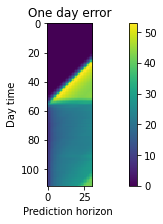

In [5]:
def main_test(model_instance):
    # images_day = images_20
    # timestamp_day = timestamp_20
    predict_horizon = 30
    error_list =[]

    dataset_sw = data.SatelliteImagesDatasetSW(root_dir = 'data/images/dia_1', 
                                           window = predict_horizon+2,
                                           transform = preprocessing.CropImage(3))
    dl_sw = DataLoader(dataset_sw, batch_size=1, collate_fn=data.collate_fn_sw)


    cmv_shift = 1 if isinstance(model_instance, model.Cmv) else 0

    for idx, samples in enumerate(dl_sw):

        if idx%50 == 0:
           print(idx)
        
        #predict depending on model
        if (isinstance(model_instance, model.Persistence)):
            predictions, _ = model_instance.predict(
                                    samples['images'][1], 
                                    samples['time_stamps'][1], 
                                    predict_horizon)
            dynamic_window = False
        elif (isinstance(model_instance, model.Cmv)):
            predictions = model_instance.predict(
                                    imgi=samples['images'][0, :, :], 
                                    imgf=samples['images'][1, :, :], 
                                    period=10*60, delta_t=10*60, 
                                    predict_horizon=predict_horizon) 
            dynamic_window = True

        #evaluate
        predict_errors = evaluate.evaluate_image(predictions, samples['images'][1:], 
            metric='RMSE',  pixel_max_value=255, dynamic_window=dynamic_window)
        error_list.append(predict_errors)
    
    return error_list


cmv2 = model.Cmv2()

error_list_cmv = main_test(cmv2)

print('Predicted for: ', len(error_list_cmv), 'images')
error_array_cmv = np.array(error_list_cmv)
print(error_array_cmv.shape)
visualization.matrix_graph(error_array_cmv)


0
50
100
Predicted for:  112 images
(112, 31)


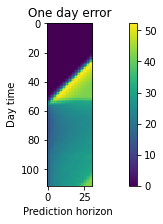

In [7]:
persistence = model.Persistence()

error_list_persistence = main_test(persistence)

print('Predicted for: ', len(error_list_persistence), 'images')
error_array_persistence = np.array(error_list_persistence)
print(error_array_persistence.shape)
visualization.matrix_graph(error_array_persistence)

# 5. Visualizacion de las imagenes: ventana que saca nans, predicciones, ventana sin nans


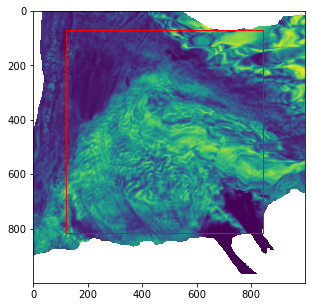

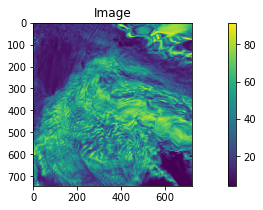

In [2]:
cmv2 = model.Cmv2()

predict_horizon = 30
dataset_sw = data.SatelliteImagesDatasetSW(root_dir = 'data/images/dia_1',
                                           window = 2,
                                           transform = preprocessing.CropImage(3))

samples = dataset_sw[100]

predictions = cmv2.predict(imgi=samples['images'][0], imgf=samples['images'][1], 
                period=10*60, delta_t=10*60, predict_horizon=predict_horizon) 


image = predictions[-1]

xmin, xmax, ymin, ymax = utils.find_inner_image(image)


fig, ax = plt.subplots()

rect = patches.Rectangle((ymin, xmin), len(image)-(ymin+ymax), len(image)-(xmin+xmax), linewidth=1, edgecolor='r', facecolor='none')

plt.imshow(image)
ax.add_patch(rect)
plt.show()

visualization.show_image_w_colorbar(image [xmin:len(image)-xmax, ymin:len(image)-ymax] )

# 6. Evaluacion de las predicciones

In [ ]:
mean_error_array_persistence = np.mean(error_array_persistence[70:100],axis=0)
mean_error_array_cmv = np.mean(error_array_cmv[70:100],axis=0)


visualization.barchart_compare2(
                mean_error_array_cmv, 'CMV',
                mean_error_arry_persistence, 'Persistence')